Discount 0.9804
  30 :       2.6996        -0.9874        -0.5068  
  31 :       2.5449        -1.1421        -0.6615  
  32 :       2.3871        -1.2998        -0.8192  
  33 :       2.2262        -1.4608        -0.9802  
  34 :       2.0621        -1.6249        -1.1443  
  35 :       1.8946        -1.7923        -1.3114  
  36 :       1.7234        -1.9632        -1.4791  
  37 :       1.5452        -2.1383        -1.6244  
  38 :       1.3312        -2.3203        -1.5485  
  39 :       0.8804        -2.4451         0.0000  
  40 :       0.0000         0.0000         0.0000  


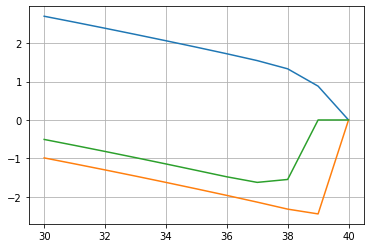

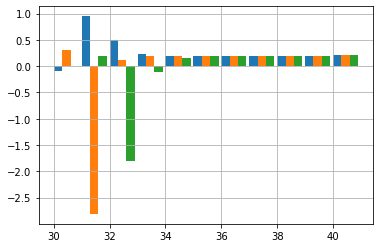

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Markov:
    def __init__(self):
        self.iNrStates = None
        self.iMaxTime  = None    
        self.dPij = []
        self.dPre = []
        self.dPost= []
        self.dv   = []
        self.dDK  = []
        self.dCF  = []
        self.bCalculated = False
        self.bCFCalculated = False
        self.iStart = None
        self.iStop  = None
    
    def vDefineModel(self,iNrStates,iMaxTime=1200):
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        for i in range(iMaxTime):
            tempPij = np.zeros([iNrStates,iNrStates])
            tempPost = np.zeros([iNrStates,iNrStates])
            tempPre = np.zeros([iNrStates])
            tempDK = np.zeros([iNrStates])
            tempCF = np.zeros([iNrStates])
            self.dPij.append(tempPij)
            self.dPost.append(tempPost)
            self.dPre.append(tempPre)
            self.dDK.append(tempDK)
            self.dCF.append(tempCF)         
        tempv = np.zeros([iMaxTime])
        self.dv=tempv
    
    def vSetDiscount(self,fIRate):
        vTemp = 1./(1.+fIRate)
        print("Discount %.4f"%(vTemp))
        for i in range(self.iMaxTime):
            self.dv[i] = vTemp
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPij(self,t,i,j,fValue):
        self.dPij[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPre(self,t,i,j,fValue):
        self.dPre[t][i] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPost(self,t,i,j,fValue):
        self.dPost[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    
    def doCalculateDK(self,iStart,iStop,iAge,iState):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.
        
        for i in range(self.iStart-1, self.iStop-1,-1):
            #print("Calc Time", i)
            for j in range(self.iNrStates):
                self.dDK[i][j] = self.dPre[i][j]
                for k in range(self.iNrStates):
                    self.dDK[i][j] += self.dv[i]*self.dPij[i][j,k]*(self.dPost[i][j,k]+self.dDK[i+1][k])
    
    def doCalculateCF(self,iStart,iStop,iAge,iState,bTrace=False):
        self.iStop = iStop
        self.iStart = iStart
        self.bCFCalculated = True
        for i in range(self.iMaxTime):
            self.dCF[i] *= 0.
        
        CurrentP = np.mat(np.identity(self.iNrStates))
        if bTrace:
            print("----- ----- ----- ----- ")
        for i in range(self.iStop, self.iStart):
            if bTrace:
                print("----- ----- ----- ----- ")
                print(" Time ", i)
                print("CF BoP", self.dCF[i])
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    self.dCF[i][k] += CurrentP[k,l] * self.dPre[i][l]
            if bTrace:
                print("CF BoP after Pre", self.dCF[i])
            NextP = np.mat(self.dPij[i])
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
                print("Next P\n", NextP) 
                print("+++++ +++++ +++++ ")
                
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    for m in range(self.iNrStates):
                        self.dCF[i+1][k] += CurrentP[k,l] * NextP[l,m] * self.dPost[i][l,m]
            if bTrace:
                print("CF EoP t", self.dCF[i])
                print("CF EoP t+1", self.dCF[i+1])
            
            CurrentP = CurrentP * NextP
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP EoP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
    
    def dGetDK(self,iStart,iStop,iAge,iState):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState])

    def dGetCF(self,iStart,iStop,iAge,iState):
        if (not(self.bCFCalculated) or self.iStart != iStart or self.iStop != iStop ):
            self.doCalculateCF(iStart,iStop,iAge,iState)
        return(self.dCF[iAge][iState])
    
    def PrintDKs(self,iStart,iStop):
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            for j in range(self.iNrStates):
                 strTemp += "   %10.4f  "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
    
    def PlotDKs(self,iStart,iStop,figNr=1):
        x = []
        y = []
        for i in range(iStop,iStart+1):
            x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetDK(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)
        
    def PlotCFs(self,iStart,iStop,figNr=2):
        import matplotlib.colors as mcolors
        A= []
        for i in mcolors.TABLEAU_COLORS.keys():
            A.append(i)
        for i in mcolors.BASE_COLORS.keys():
            A.append(i)
        
        xBar =[]
        hBar =[]
        bBar =[]
        cBar =[]
        y = []
        for i in range(iStop,iStart+1):
            for j in range(self.iNrStates):
                xBar.append(i+(0.5+j)*0.9/self.iNrStates)
                hBar.append(self.dGetCF(iStart,iStop,i,j))
                bBar.append(0)
                cBar.append(A[j])
            
        plt.figure(figNr)
        plt.bar(xBar,hBar,bottom=bBar, width = 0.9/self.iNrStates,color=cBar)
        plt.grid(True)

symM = Markov()

symM.vDefineModel(3)

symM.vSetDiscount(0.02)

iStart = 40
iStop = 30

for i in range(30,40):
    symM.vSetPij(i,0,0,0.8)
    symM.vSetPij(i,0,1,0.1)
    symM.vSetPij(i,0,2,0.1)
    symM.vSetPij(i,1,0,0.7)
    symM.vSetPij(i,1,1,0.2)
    symM.vSetPij(i,1,2,0.1)
    symM.vSetPij(i,2,0,0.15)
    symM.vSetPij(i,2,1,0.7)
    symM.vSetPij(i,2,2,0.15)
    symM.vSetPre(i,0,0,-0.10)
    symM.vSetPre(i,1,0,0.30)
    symM.vSetPost(i,0,2,10)
    symM.vSetPost(i,1,0,-4)

symM.PrintDKs(iStart,iStop)
symM.PlotDKs(iStart,iStop)
symM.PlotCFs(iStart,iStop)               


    


Discount 0.9662
Discount 0.9662
Premium 2156.996365
  30 :       0.0000         0.0000  
  31 :    1987.7420         0.0000  
  32 :    4026.9884         0.0000  
  33 :    6118.3085         0.0000  
  34 :    8262.2191         0.0000  
  35 :   10459.1803         0.0000  
  36 :   12709.5903         0.0000  
  37 :   15013.7813         0.0000  
  38 :   17372.0144         0.0000  
  39 :   19784.4750         0.0000  
  40 :   22251.2680         0.0000  
  41 :   24772.4137         0.0000  
  42 :   27347.8432         0.0000  
  43 :   29977.3948         0.0000  
  44 :   32660.8099         0.0000  
  45 :   35397.7305         0.0000  
  46 :   38187.6961         0.0000  
  47 :   41030.1423         0.0000  
  48 :   43924.3998         0.0000  
  49 :   46869.6945         0.0000  
  50 :   49865.1485         0.0000  
  51 :   52909.7835         0.0000  
  52 :   56002.5249         0.0000  
  53 :   59142.2081         0.0000  
  54 :   62327.5878         0.0000  
  55 :   65557.3490    

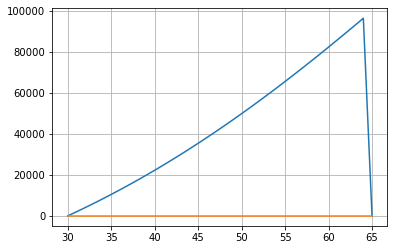

In [2]:
def mu(x):
    return(np.exp(-9.13275+0.0809*x+0.000011*x*x))

symM = Markov()

symM.vDefineModel(2)

symM.vSetDiscount(0.035)

symMP = Markov()

symMP.vDefineModel(2)

symMP.vSetDiscount(0.035)



iStart = 65
iStop = 30
PP = -2129

for i in range(30,65):
    qx = mu(i)
    symM.vSetPij(i,0,0,1-qx)
    symM.vSetPij(i,0,1,qx)
    symM.vSetPij(i,1,1,1.)
    symM.vSetPost(i,0,1,200000.)
    symM.vSetPre(i,0,0,0)
    symMP.vSetPij(i,0,0,1-qx)
    symMP.vSetPij(i,0,1,qx)
    symMP.vSetPij(i,1,1,1.)
    symMP.vSetPost(i,0,1,0.)
    symMP.vSetPre(i,0,0,1)

symM.vSetPost(iStart-1,0,0,100000.)

PP = symM.dGetDK(iStart,iStop,iStop,0)/symMP.dGetDK(iStart,iStop,iStop,0)

print("Premium %f"%(PP))

for i in range(30,65):
    qx = mu(i)
    symM.vSetPij(i,0,0,1-qx)
    symM.vSetPij(i,0,1,qx)
    symM.vSetPij(i,1,1,1.)
    symM.vSetPost(i,0,1,200000.)
    symM.vSetPre(i,0,0,-PP)

symM.PrintDKs(iStart,iStop)
symM.PlotDKs(iStart,iStop)



Discount 0.9662
Discount 0.9662
Premium -1.284766
  35 :   49472.8083         0.0000  
  36 :   50927.2466         0.0000  
  37 :   52412.0003         0.0000  
  38 :   53926.6916         0.0000  
  39 :   55470.8375         0.0000  
  40 :   57043.8413         0.0000  
  41 :   58644.9829         0.0000  
  42 :   60273.4087         0.0000  
  43 :   61928.1207         0.0000  
  44 :   63607.9648         0.0000  
  45 :   65311.6181         0.0000  
  46 :   67037.5751         0.0000  
  47 :   68784.1330         0.0000  
  48 :   70549.3750         0.0000  
  49 :   72331.1532         0.0000  
  50 :   74127.0680         0.0000  
  51 :   75934.4468         0.0000  
  52 :   77750.3193         0.0000  
  53 :   79571.3900         0.0000  
  54 :   81394.0068         0.0000  
  55 :   83214.1256         0.0000  
  56 :   85027.2690         0.0000  
  57 :   86828.4791         0.0000  
  58 :   88612.2616         0.0000  
  59 :   90372.5212         0.0000  
  60 :   92102.4839      

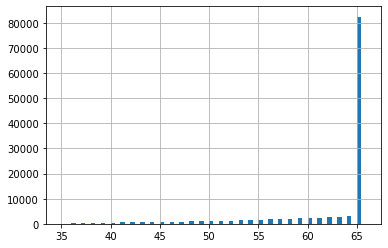

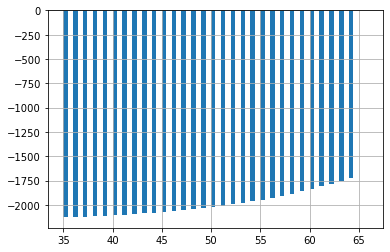

In [3]:
symMB = Markov()
symMP = Markov()

symMB.vDefineModel(2)
symMP.vDefineModel(2)

symMB.vSetDiscount(0.035)
symMP.vSetDiscount(0.035)





iStart = 65
iStop = 35
PP = -2129

for i in range(30,65):
    qx = mu(i)
    symMB.vSetPij(i,0,0,1-qx)
    symMB.vSetPij(i,0,1,qx)
    symMB.vSetPij(i,1,1,1.)
    symMB.vSetPost(i,0,1,200000.)
    symMB.vSetPre(i,0,0,0)
    symMP.vSetPij(i,0,0,1-qx)
    symMP.vSetPij(i,0,1,qx)
    symMP.vSetPij(i,1,1,1.)
    symMP.vSetPost(i,0,1,0.)
    symMP.vSetPre(i,0,0,1*PP)

symMB.vSetPost(iStart-1,0,0,100000.)

PP = symMB.dGetDK(iStart,iStop,iStop,0)/symMP.dGetDK(iStart,iStop,iStop,0)

print("Premium %f"%(PP))

symMB.PlotCFs(iStart,iStop,figNr=3)
symMP.PlotCFs(iStart,iStop,figNr=4)

symMB.PrintDKs(iStart,iStop)
symMP.PrintDKs(iStart,iStop)

print("MR at 35:", 49472.8083-38509)

In [4]:
symMB.vSetDiscount(0.045)
symMP.vSetDiscount(0.045)

symMB.PrintDKs(iStart,iStop)
symMP.PrintDKs(iStart,iStop)

print("MR at 35:", 49472.8083-38509)

print("MR (Market Conistent at 35:", 39007.6869-34573.2668)

Discount 0.9569
Discount 0.9569
  35 :   39007.6869         0.0000  
  36 :   40466.4773         0.0000  
  37 :   41968.7037         0.0000  
  38 :   43514.7768         0.0000  
  39 :   45105.0324         0.0000  
  40 :   46739.7241         0.0000  
  41 :   48419.0151         0.0000  
  42 :   50142.9706         0.0000  
  43 :   51911.5489         0.0000  
  44 :   53724.5927         0.0000  
  45 :   55581.8198         0.0000  
  46 :   57482.8137         0.0000  
  47 :   59427.0138         0.0000  
  48 :   61413.7049         0.0000  
  49 :   63442.0068         0.0000  
  50 :   65510.8634         0.0000  
  51 :   67619.0309         0.0000  
  52 :   69765.0663         0.0000  
  53 :   71947.3147         0.0000  
  54 :   74163.8961         0.0000  
  55 :   76412.6917         0.0000  
  56 :   78691.3286         0.0000  
  57 :   80997.1638         0.0000  
  58 :   83327.2660         0.0000  
  59 :   85678.3960         0.0000  
  60 :   88046.9838         0.0000  
  61 :

What is the interest rate risk
Discount 0.9852
Discount 0.9852
Discount 0.9804
Discount 0.9804
Discount 0.9756
Discount 0.9756
Discount 0.9709
Discount 0.9709
Discount 0.9662
Discount 0.9662
Discount 0.9615
Discount 0.9615
Discount 0.9569
Discount 0.9569
Discount 0.9524
Discount 0.9524
Discount 0.9479
Discount 0.9479


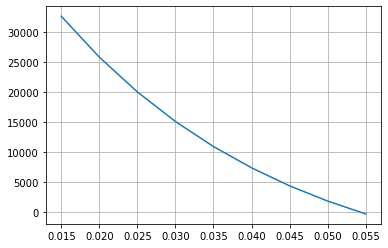

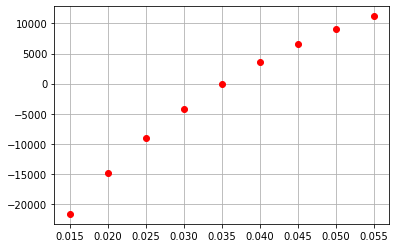

In [5]:
print("What is the interest rate risk")

iR = [0.035-0.02,0.035-0.015,0.035-0.01,0.035-0.005,0.035, 0.035+0.005, 0.035+0.01, 0.035+0.015, 0.035+0.02 ]
MR =[]

for iRate in iR:
    symMB.vSetDiscount(iRate)
    symMP.vSetDiscount(iRate)
    MR.append(symMB.dGetDK(iStart,iStop,iStop,0)+symMP.dGetDK(iStart,iStop,iStop,0))
    
    
plt.figure(1)
plt.plot(iR,MR)
plt.grid(True)
    
PnL =[]
iMid = 4
for i in range(len(MR)):
    PnL.append(MR[iMid]-MR[i])
    
plt.figure(2)
plt.plot(iR,PnL,"ro")
plt.grid(True)  


In [41]:
nBond = 10
vBond = 10963.808299999997
iNeutral = iR[iMid]
print("Example ALM with a %d year Bond"%(nBond))
fNom = vBond * (1. + iNeutral)**nBond
print("Nominal Value of Bond %.2f"%(fNom))

Example ALM with a 10 year Bond
Nominal Value of Bond 15465.53


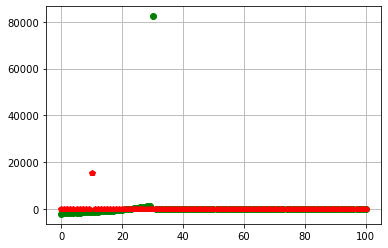

In [42]:
CFLiab = []
CFAssets = []
n=101

for i in range(n):
    CFLiab.append(symMB.dGetCF(iStart,iStop,iStop+i,0)+symMP.dGetCF(iStart,iStop,iStop+i,0))
    if (i == nBond):
        fCFBond = fNom
    else:
        fCFBond = 0
    CFAssets.append(fCFBond)
    
plt.figure(2)
plt.plot(range(n),CFLiab,"go",range(n),CFAssets,"rp")
plt.grid(True)  

In [39]:
def Value(CF, iRate): #Here only one risk factor namely flat rate
    dTemp = 0
    for i in range(len(CF)):
        dTemp += CF[i] *(1+iRate)**(-i)
    return(dTemp)

# Assume you have the interest to maturity of ZCB  price = (1+in)^(-n)
# We can use a more elaborated valuation

def ValueIRVec(CF, iRateVect): #Here only one risk factor namely flat rate
    dTemp = 0
    for i in range(len(CF)):
        dTemp += CF[i] *(1+iRateVect[i])**(-i)
    return(dTemp)


print(Value(CFLiab, 0.035))
print(Value(CFAssets, 0.035))



10965.55095695028
10963.808299999999


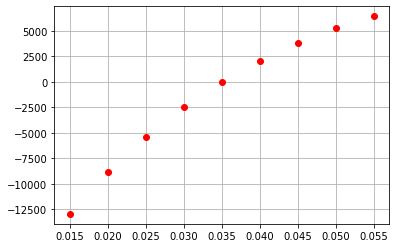

In [40]:
PnL =[]
iMid = 4
for i in range(len(iR)):
    iNeutral = iR[iMid]
    iStressed = iR[i]
    ValueNeutral= Value(CFAssets, iNeutral) - Value(CFLiab, iNeutral)  
    ValueStressed = Value(CFAssets, iStressed) - Value(CFLiab, iStressed) 
    PnL.append(ValueStressed-ValueNeutral)
    
plt.figure(2)
plt.plot(iR,PnL,"ro")
plt.grid(True)  
